In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
stock = "POWERGRID.NS"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2026, 1, 1)

df = yf.download(stock, start, end)
df = df[['Close']]
print(df.tail())


/tmp/ipython-input-2185162991.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start, end)
[*********************100%***********************]  1 of 1 completed

Price             Close
Ticker     POWERGRID.NS
Date                   
2025-12-24   268.049988
2025-12-26   265.450012
2025-12-29   260.600006
2025-12-30   260.350006
2025-12-31   264.600006


In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4497 entries, 2007-10-05 to 2025-12-31
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Close, POWERGRID.NS)  4497 non-null   float64
dtypes: float64(1)
memory usage: 70.3 KB


In [29]:
df.isnull().sum()


,,0
Price,Ticker,
Close,POWERGRID.NS,0


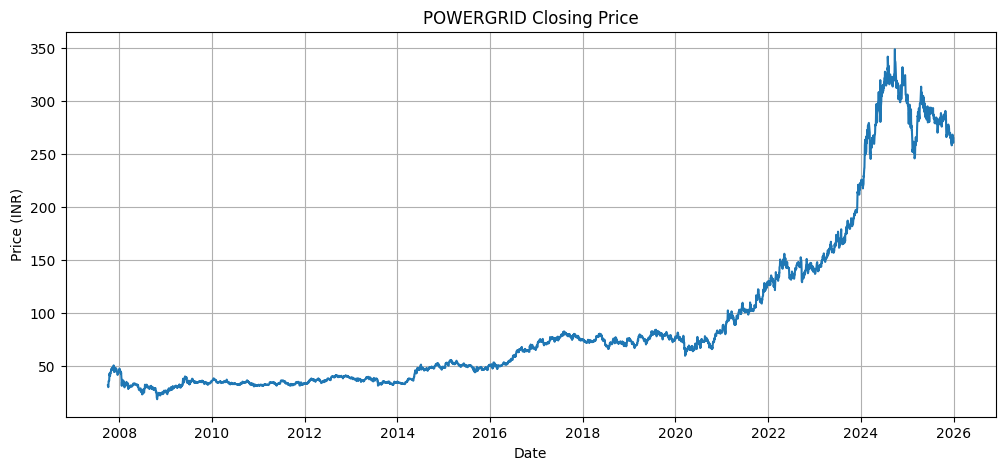

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title("POWERGRID Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid()
plt.show()


💹
The closing price shows a clear long-term trend, indicating non-stationary behavior.

Periods of sustained upward and sideways movement suggest market cycles.

Sudden spikes or drops correspond to market events or sentiment changes.

The presence of trend justifies the use of sequence-based models like LSTM instead of simple linear models.





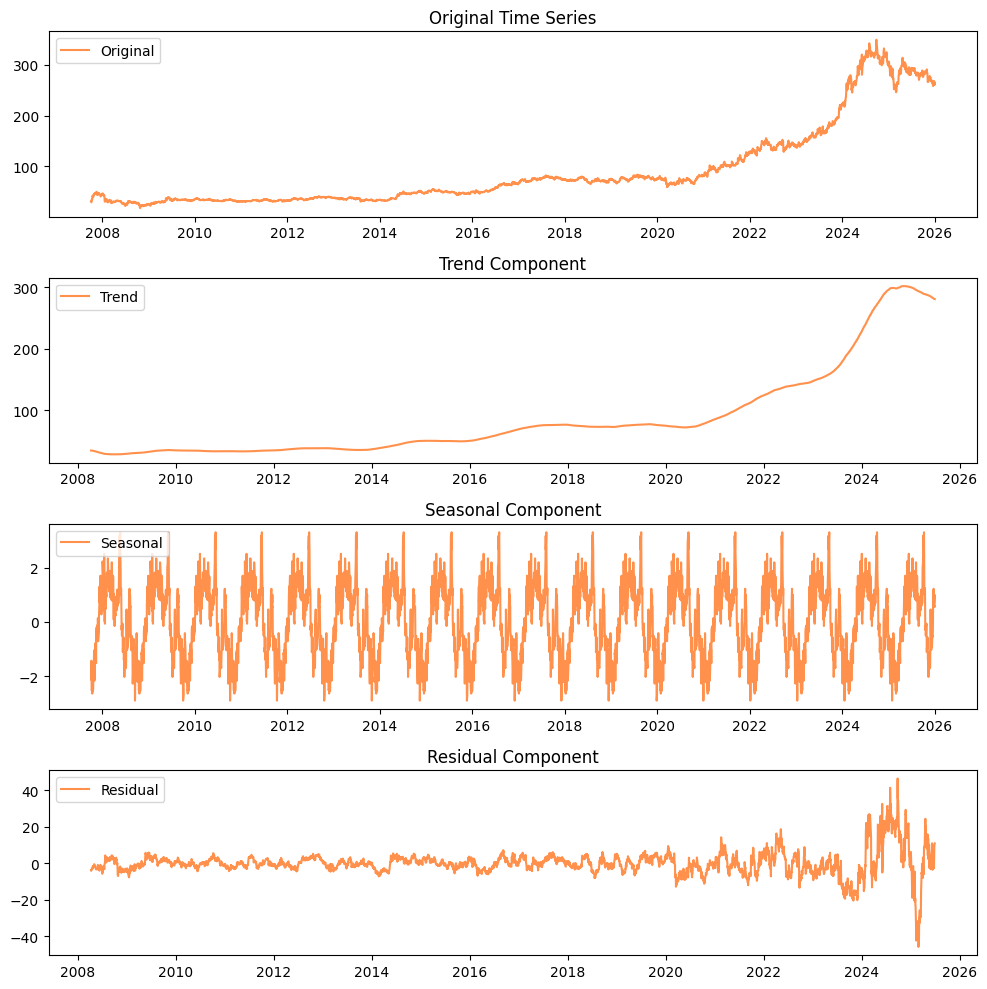

In [30]:
# 🧠 Decompose the time series (additive model, 30-day period)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Close'], model='additive', period=252)

# 🔍 Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# 🎨 Plot all components
plt.figure(figsize=(10, 10))

# Original
plt.subplot(4, 1, 1)
plt.plot(df['Close'], label='Original', color='#FF914D')
plt.title('Original Time Series')
plt.legend(loc='upper left')

# Trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='#FF914D')
plt.title('Trend Component')
plt.legend(loc='upper left')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='#FF914D')
plt.title('Seasonal Component')
plt.legend(loc='upper left')

# Residual
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='#FF914D')
plt.title('Residual Component')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Rolling Mean & Rolling Std**

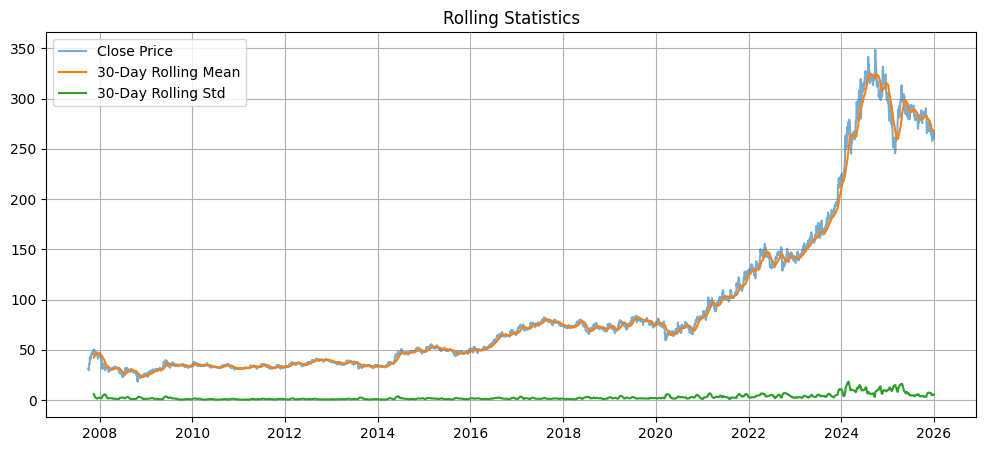

In [31]:
rolling_window = 30

df['Rolling_Mean'] = df['Close'].rolling(window=rolling_window).mean()
df['Rolling_STD'] = df['Close'].rolling(window=rolling_window).std()

plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Close Price', alpha=0.6)
plt.plot(df['Rolling_Mean'], label='30-Day Rolling Mean')
plt.plot(df['Rolling_STD'], label='30-Day Rolling Std')
plt.legend()
plt.title("Rolling Statistics")
plt.grid()
plt.show()


📉  — Insights

The rolling mean smooths short-term fluctuations and highlights the underlying trend.

Rolling standard deviation varies over time, indicating changing volatility regimes.

Higher volatility periods often align with strong market movements or uncertainty.

Time-varying mean and variance further confirm non-stationarity in the data

**Daily Returns Analysis**

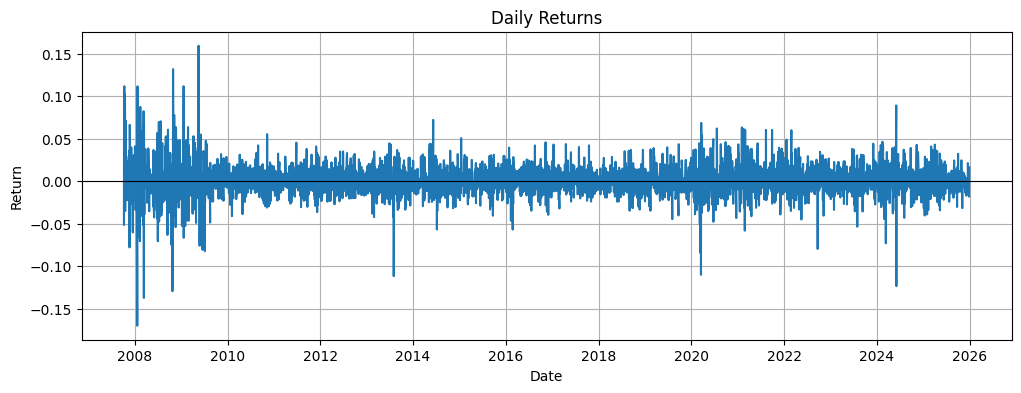

In [32]:
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(12,4))
plt.plot(df.index, df['Daily_Return'])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid()
plt.show()


📊 Daily Returns Analysis — Insights

Daily returns fluctuate around zero, as expected in financial time series.

Large positive and negative spikes indicate high-impact market days.

Volatility clustering is visible, where periods of high volatility follow each other.

Returns provide a clearer view of risk and short-term price movement than raw prices.

**Moving Averages**

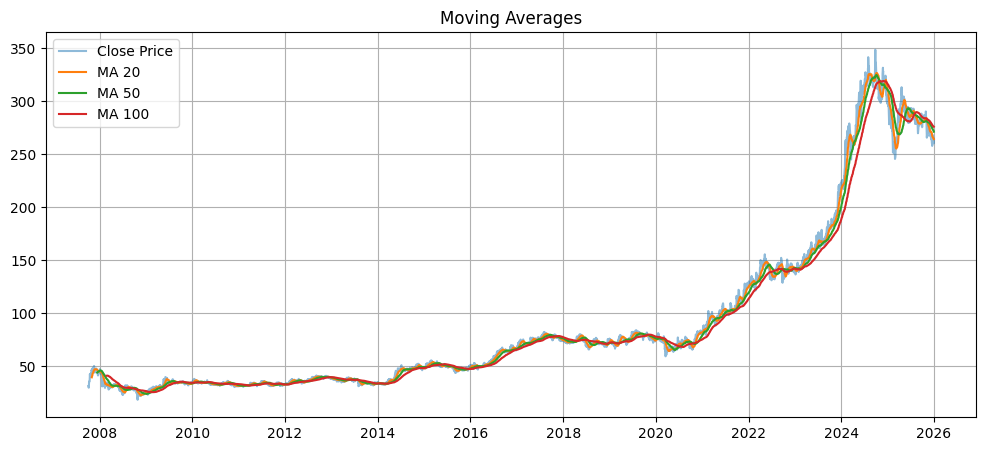

In [33]:
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_100'] = df['Close'].rolling(window=100).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA_20'], label='MA 20')
plt.plot(df['MA_50'], label='MA 50')
plt.plot(df['MA_100'], label='MA 100')
plt.legend()
plt.title("Moving Averages")
plt.grid()
plt.show()


🔁 Insights

Short-term moving averages react quickly to price changes, capturing recent momentum.

Long-term moving averages represent overall market direction.

Crossovers between short and long MAs indicate potential trend shifts.

Moving averages help reduce noise and provide technical confirmation of trends.

**Volatility Over Time**

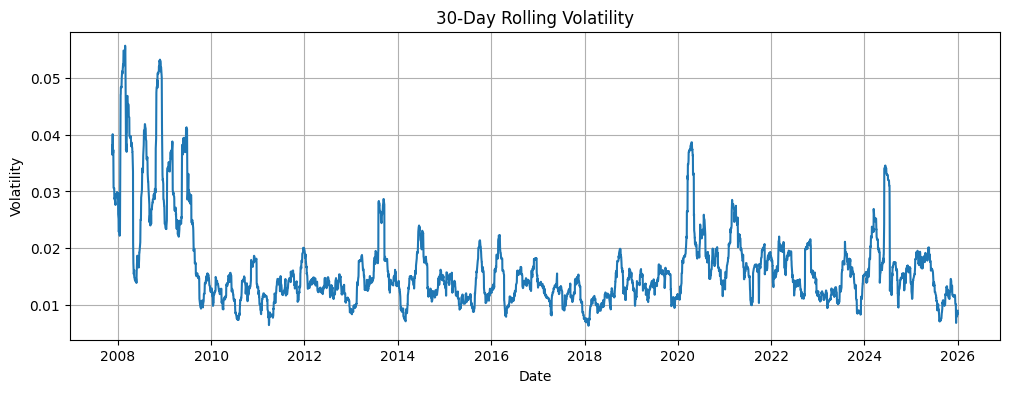

In [35]:
df['Volatility'] = df['Daily_Return'].rolling(30).std()

plt.figure(figsize=(12,4))
plt.plot(df['Volatility'])
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid()
plt.show()


Scale the Data

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']])


Train–Test Split

In [5]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


Create Time-Series Sequences

In [6]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


**Train the Model**

In [9]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(60,1)))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0028 - val_loss: 7.8385e-04
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 1.9132e-04 - val_loss: 0.0013
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 1.6175e-04 - val_loss: 0.0014
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 1.6983e-04 - val_loss: 0.0010
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 1.3934e-04 - val_loss: 0.0019
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 1.3723e-04 - val_loss: 5.8017e-04
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 1.3714e-04 - val_loss: 5.1732e-04
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 1.0142e-04 - val_loss: 9.6135e-04
Epoch 9/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.0573e-04 - val_loss: 6.6365e-04
Epoch 10/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.1004e-04 - val_loss: 8.8468e-04
Epoch 11/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 1.0

Predict on Test Data

In [11]:
test_predictions = model.predict(X_test)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [12]:
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
print("RMSE:", rmse)


RMSE: 6.63946092706334


In [14]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_actual, test_predictions)
print("MAE:", mae)


MAE: 4.792292731148856


**Plot Actual vs Predicted**

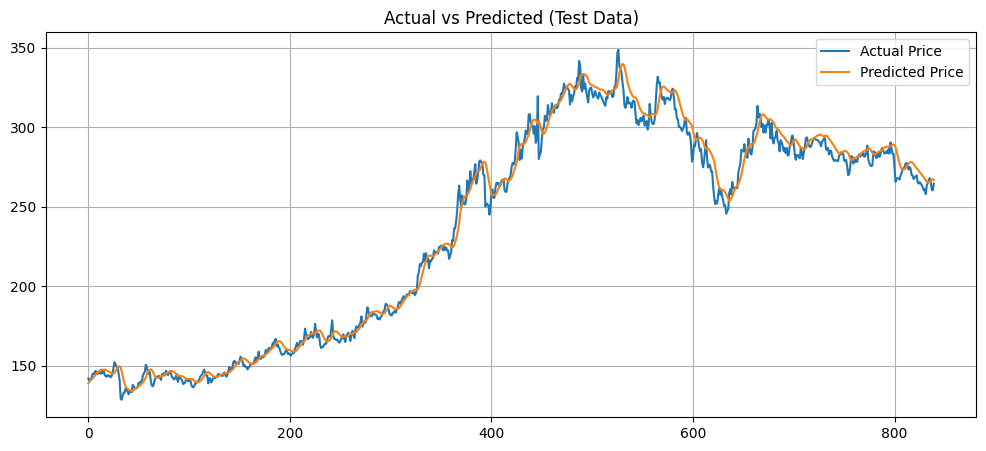

In [15]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(test_predictions, label="Predicted Price")
plt.title("Actual vs Predicted (Test Data)")
plt.legend()
plt.grid()
plt.show()


In [16]:
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 1.99%


In [17]:
model.save("powergrid_lstm_model.h5")
print("Model saved successfully")


Model saved successfully


In [18]:
model = load_model("powergrid_lstm_model.h5")


**🔮 NEXT 30 DAYS FORECAST**

In [19]:
last_60_days = scaled_data[-60:]
future_input = last_60_days.reshape(1, 60, 1)


In [20]:
future_prices = []

for _ in range(30):
    next_price = model.predict(future_input, verbose=0)
    future_prices.append(next_price[0][0])

    future_input = np.append(
        future_input[:, 1:, :],
        next_price.reshape(1, 1, 1),
        axis=1
    )


In [21]:
future_prices = scaler.inverse_transform(
    np.array(future_prices).reshape(-1, 1)
)


In [22]:
last_date = df.index[-1]

future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=30,
    freq='B'   # Business days (Mon–Fri)
)


In [23]:
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close_Price": future_prices.flatten()
}).set_index("Date")


In [24]:
print(forecast_df)


            Predicted_Close_Price
Date                             
2026-01-01             266.803192
2026-01-02             267.097046
2026-01-05             267.589020
2026-01-06             268.192047
2026-01-07             268.858093
2026-01-08             269.560699
2026-01-09             270.285126
2026-01-12             271.023163
2026-01-13             271.769958
2026-01-14             272.522858
2026-01-15             273.280304
2026-01-16             274.041229
2026-01-19             274.804993
2026-01-20             275.571075
2026-01-21             276.339264
2026-01-22             277.109314
2026-01-23             277.881073
2026-01-26             278.654358
2026-01-27             279.429108
2026-01-28             280.205261
2026-01-29             280.982605
2026-01-30             281.761292
2026-02-02             282.541168
2026-02-03             283.322021
2026-02-04             284.104065
2026-02-05             284.887146
2026-02-06             285.671234
2026-02-09    

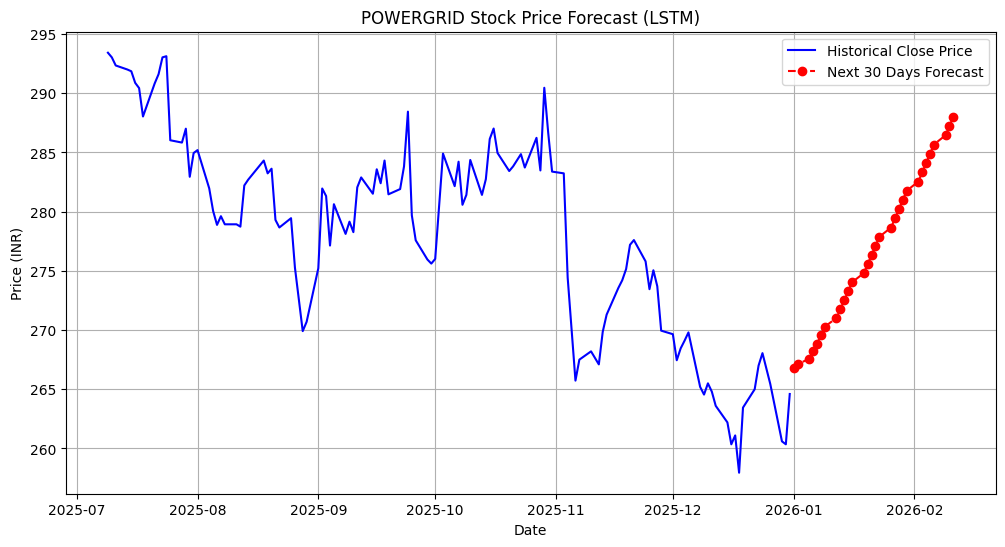

In [25]:
plt.figure(figsize=(12,6))

# Historical data (last 120 days for clarity)
plt.plot(
    df.index[-120:],
    df['Close'].tail(120),
    label="Historical Close Price",
    color="blue"
)

# Future forecast
plt.plot(
    forecast_df.index,
    forecast_df['Predicted_Close_Price'],
    label="Next 30 Days Forecast",
    color="red",
    linestyle="--",
    marker="o"
)

plt.title("POWERGRID Stock Price Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid()
plt.show()
